In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
from rasterio.plot import show
from rasterio.io import MemoryFile
import os
import datetime

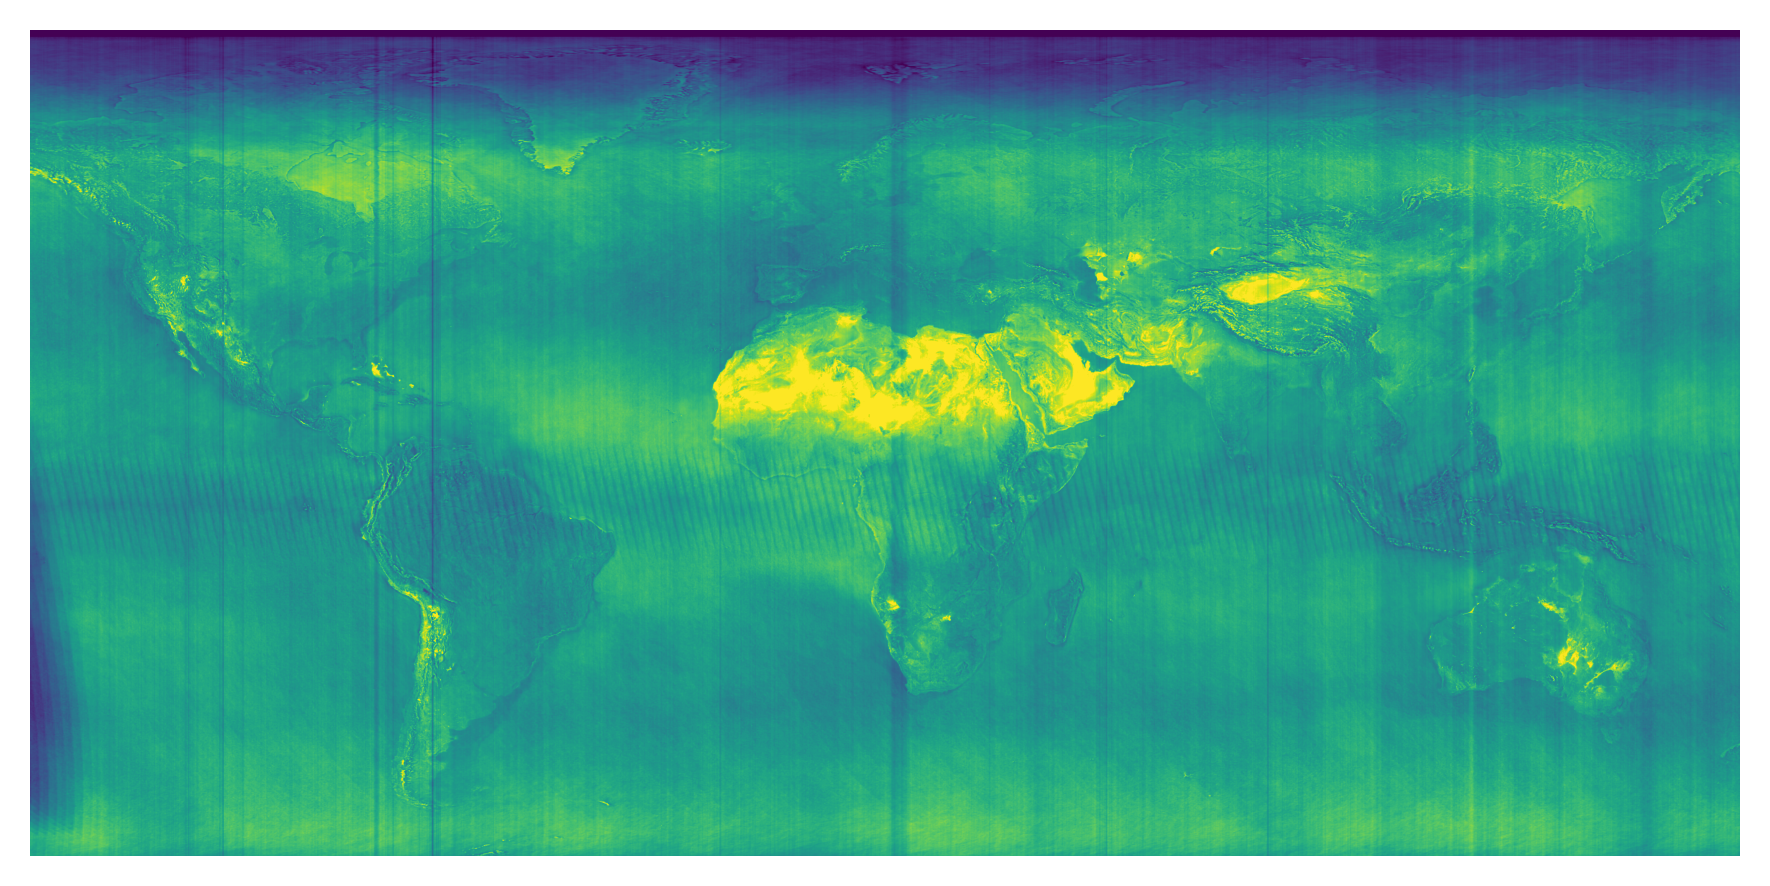

In [34]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ~~~~~~~~~ Create Average of Multiple Days Plot ~~~~~~~~~~~~
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# --- filter out inapplicable files ---
path_dir = os.path.join(os.pardir, 'data','s3','clean')
files = os.listdir(path_dir)
files = [f for f in files if '.tif' in f]

emission = 'AER'
freq = 3

# --- open files with rasterio ---
src_files = []
for f in files:
    if emission in f:
        date = f[-14:].replace('.tif','')
        dt = datetime.datetime.strptime(date, '%Y-%m-%d')
        if dt.year == 2019:
            src_files.append(f)

src_files.sort()

# --- grab arrays from dates ---

arrays = []
for f in src_files[::freq]:
    with rasterio.open(os.path.join(path_dir, f), 'r+') as dataset:
        src = dataset.read()
        profile = dataset.meta.copy()
        arrays.append(src)

# --- average array ---
avg = np.mean(arrays, axis=0)
avg = np.clip(avg, np.percentile(avg, 7), np.percentile(avg, 99.5))
profile['dtype'] = avg.dtype

# --- plot ---
with MemoryFile() as memfile:
    with memfile.open(**profile) as dataset:
        dataset.write(avg)
        fig, ax = plt.subplots(dpi=300)
        ax.imshow(dataset.read(1))
        ax.set_xlim(1100, 10000)
        ax.set_ylim(4400, 100)
        plt.axis('off')

plt.tight_layout()
plt.savefig(os.path.join('../..','dirt','app','static',f'jumbotron_emissions_{emission}.png'))
    
